# Sinaplots

from here https://cran.r-project.org/web/packages/sinaplot/vignettes/SinaPlot.html

A cool way to display data with as much info as possible, including the number of data points, the distribution and density, mean or median, and outliers. Now in python, because I didn't want to write my 2nd year report this afternoon.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sinaplot import sinaplot
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

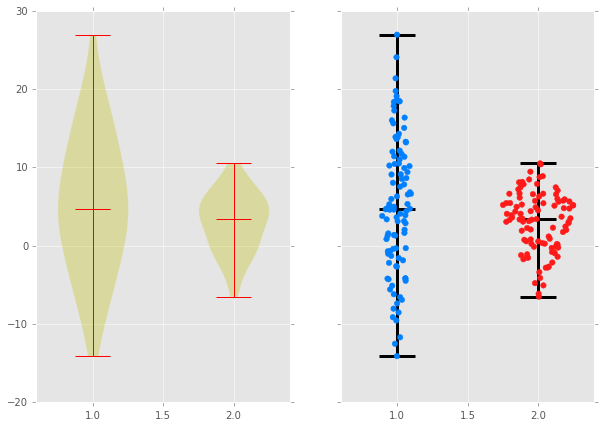

In [18]:
y1 = np.random.normal(4, 10, 100)
y2 = np.random.normal(3, 4, 100)
data = np.vstack((y1, y2)).T

fig, ax = plt.subplots(figsize=(10, 7), ncols=2, sharey=True, sharex=True)

vio = ax[0].violinplot(
    data, points=200, vert=True, widths=0.5, 
    showextrema=True, showmedians=True, bw_method=0.5)

sina = sinaplot(
    data, showmedians=True, showextrema=True,
    scaled=True, vert=True, ax=ax[1],
    scatter_kwargs={'s': 30, 'color': ['#0080ff', '#ff1a1a'], 'zorder': 10},
    line_kwargs={'lw': 3, 'color': 'k', 'zorder': 1})

In [3]:
sina

{'cbars': <matplotlib.collections.LineCollection at 0x7feac2861f28>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feac2854780>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7feac285dc50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feac2865898>,
 'scatter': <matplotlib.collections.PathCollection at 0x7feac281cd68>}